# Setup

In [ ]:
# ================================================================================
# CÉLULA 1: INSTALAÇÃO
# ================================================================================
%pip install tabm rtdl_num_embeddings optuna

In [1]:
# ================================================================================
# CÉLULA 2: IMPORTS E CONFIGURAÇÕES
# ================================================================================
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors

import warnings
import optuna

import json
import os

try:
    from tabm import TabM
    from rtdl_num_embeddings import PiecewiseLinearEmbeddings
    print("TabM e rtdl_num_embeddings importados com sucesso!")
except ImportError as e:
    print(f"Bibliotecas não encontradas: {e}")

warnings.filterwarnings('ignore')

# Configurações
N_SPLITS = 10
RANDOM_STATE = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Usando dispositivo: {DEVICE}")

# URL do dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Nomes das colunas
columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 
           'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target']

TabM e rtdl_num_embeddings importados com sucesso!
Usando dispositivo: cpu


# EDA e Pré-Processamento

Shape numérico: (297, 5)
Shape categórico: (297, 8)
Cardinalidades: [2, 4, 2, 3, 2, 3, 4, 3]
Distribuição do target: [160 137]


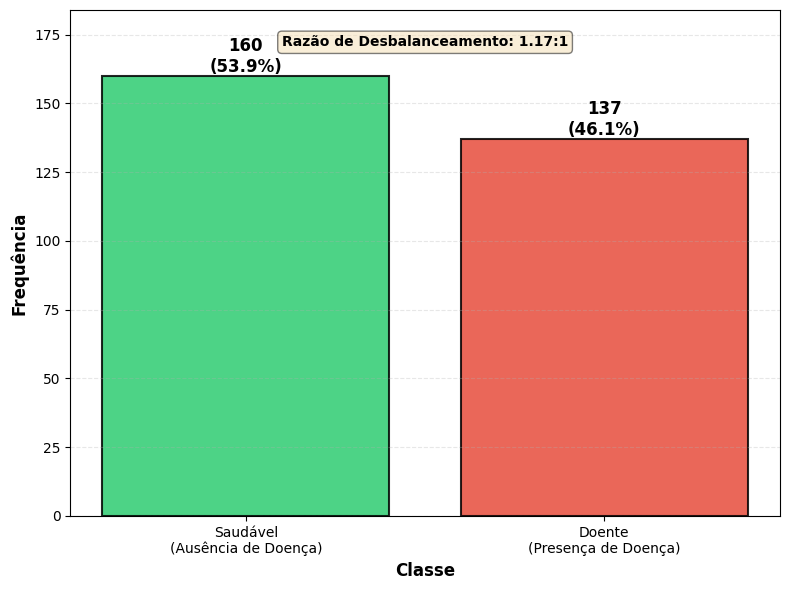


Resumo da Distribuição:
  Classe 0 (Saudável): 160 (53.9%)
  Classe 1 (Doente): 137 (46.1%)
  Razão: 1.17:1


In [2]:
# ================================================================================
# CÉLULA 3: CARREGAMENTO E PRÉ-PROCESSAMENTO DE DADOS
# ================================================================================
def load_and_process_data(url, columns):
    # Carregar dados
    # O dataset tem valores ausentes marcados com '?'
    df = pd.read_csv(url, names=columns, na_values='?')
    
    # Tratar valores ausentes (remoção simples para este MVP)
    df = df.dropna()
    
    # Converter target para binário (0 = ausência, 1-4 = presença)
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    # Separar features numéricas e categóricas
    # Numéricas: age, trestbps, chol, thalach, oldpeak
    num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    # Categóricas: sex, cp, fbs, restecg, exang, slope, ca, thal
    cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    # Padronizar features numéricas
    scaler = StandardScaler()
    df[num_features] = scaler.fit_transform(df[num_features])
    
    # Codificar categóricas para índices (0 a C-1) para uso com TabM
    cat_cardinalities = []
    for col in cat_features:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        cat_cardinalities.append(len(le.classes_))
    
    X_num = df[num_features].values.astype(np.float32)
    X_cat = df[cat_features].values.astype(np.int64)
    y = df['target'].values.astype(np.float32).reshape(-1, 1)
    
    return X_num, X_cat, y, num_features, cat_features, cat_cardinalities

X_num, X_cat, y, feature_names_num, feature_names_cat, cat_cardinalities = load_and_process_data(url, columns)

print(f"Shape numérico: {X_num.shape}")
print(f"Shape categórico: {X_cat.shape}")
print(f"Cardinalidades: {cat_cardinalities}")
print(f"Distribuição do target: {np.bincount(y.flatten().astype(int))}")

# ================================================================================
# PLOT: DISTRIBUIÇÃO DO TARGET
# ================================================================================

# Calcular frequências
target_counts = np.bincount(y.flatten().astype(int))
labels = ['Saudável\n(Ausência de Doença)', 'Doente\n(Presença de Doença)']
percentages = (target_counts / target_counts.sum()) * 100

# Criar figura
fig, ax = plt.subplots(figsize=(8, 6))

# Gráfico de barras
bars = ax.bar(labels, target_counts, color=['#2ecc71', '#e74c3c'], 
              edgecolor='black', linewidth=1.5, alpha=0.85)

# Adicionar valores e percentuais nas barras
for bar, count, pct in zip(bars, target_counts, percentages):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

# Configurações do gráfico
ax.set_ylabel('Frequência', fontsize=12, fontweight='bold')
ax.set_xlabel('Classe', fontsize=12, fontweight='bold')
ax.grid(axis='y', alpha=0.3, linestyle='--')
ax.set_ylim([0, max(target_counts) * 1.15])

# Adicionar informação adicional
ratio = target_counts[0] / target_counts[1]
ax.text(0.5, 0.95, f'Razão de Desbalanceamento: {ratio:.2f}:1', 
        transform=ax.transAxes, ha='center', va='top',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
        fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nResumo da Distribuição:")
print(f"  Classe 0 (Saudável): {target_counts[0]} ({percentages[0]:.1f}%)")
print(f"  Classe 1 (Doente): {target_counts[1]} ({percentages[1]:.1f}%)")
print(f"  Razão: {ratio:.2f}:1")

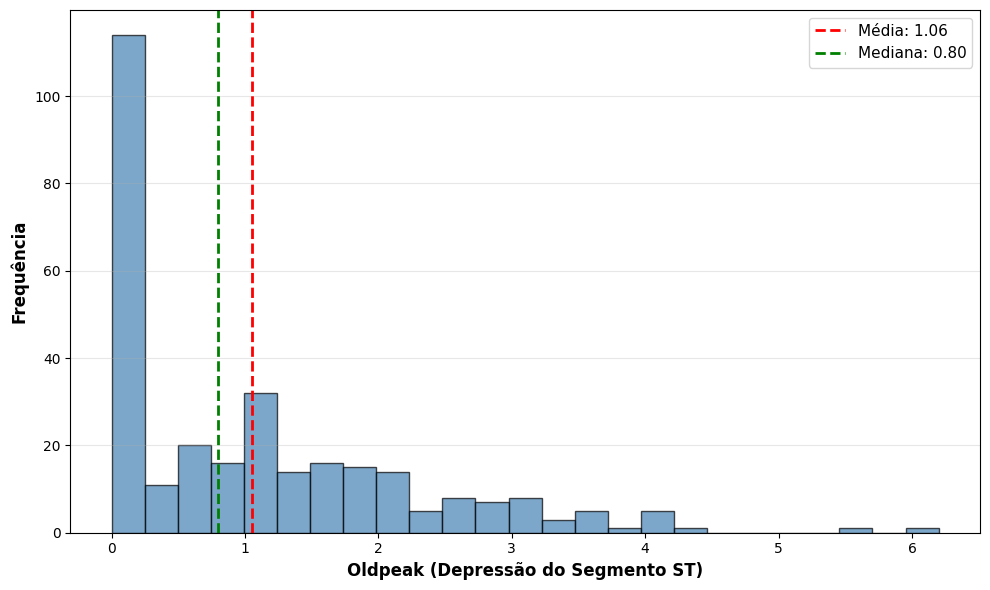

OLDPEAK - Estatísticas Descritivas
Média: 1.0556
Mediana: 0.8000
Desvio Padrão: 1.1661
Mínimo: 0.0000
Máximo: 6.2000
Assimetria: Distribuição concentrada em valores próximos a zero com cauda longa



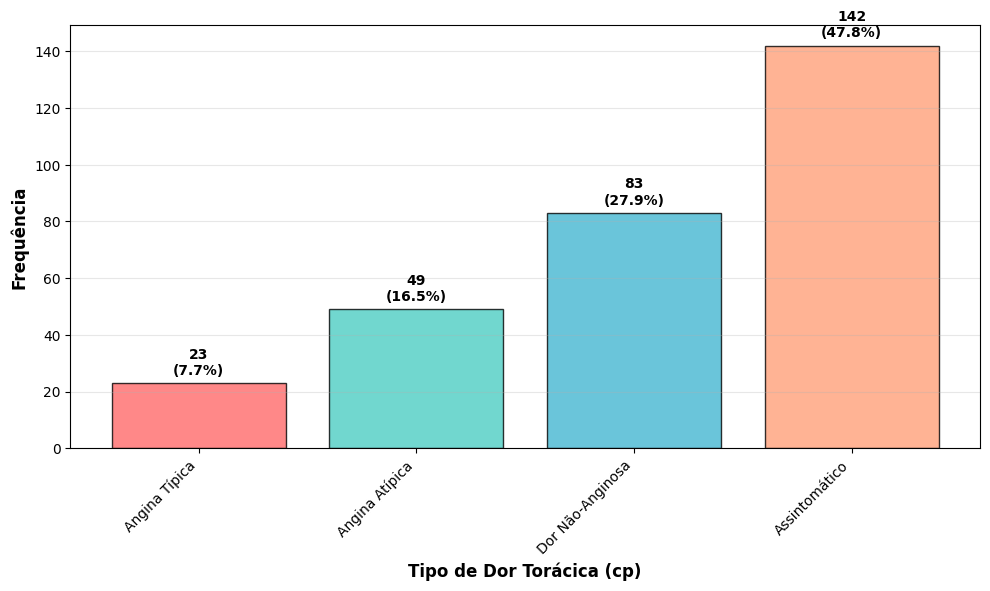

CP (Tipo de Dor Torácica) - Distribuição de Frequências
Angina Típica: 23 amostras (7.7%)
Angina Atípica: 49 amostras (16.5%)
Dor Não-Anginosa: 83 amostras (27.9%)
Assintomático: 142 amostras (47.8%)



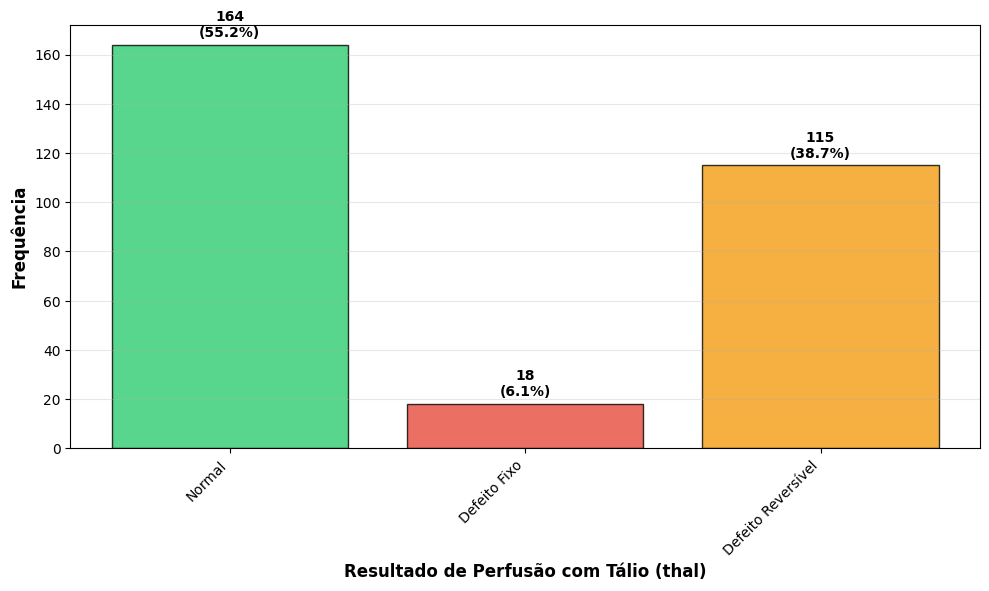

THAL (Resultado de Perfusão com Tálio) - Distribuição de Frequências
Normal: 164 amostras (55.2%)
Defeito Fixo: 18 amostras (6.1%)
Defeito Reversível: 115 amostras (38.7%)



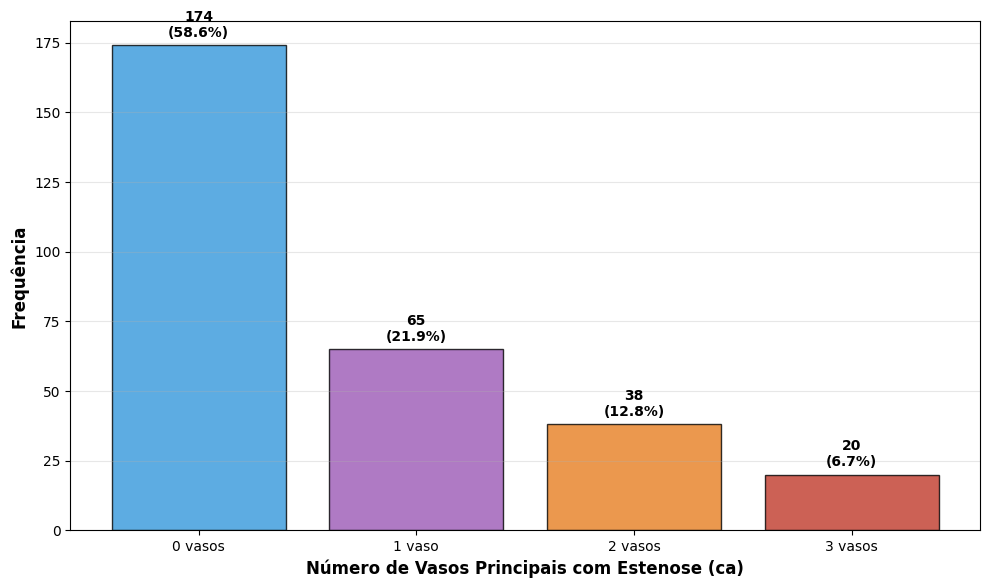

CA (Número de Vasos com Estenose) - Distribuição de Frequências
0 vasos: 174 amostras (58.6%)
1 vaso: 65 amostras (21.9%)
2 vasos: 38 amostras (12.8%)
3 vasos: 20 amostras (6.7%)
Observação: Concentração forte em valores baixos (0 e 1)



In [3]:
# ================================================================================
# CÉLULA 3.1: ANÁLISE DE DISTRIBUIÇÕES
# ================================================================================
# Recarregar dados originais (antes da seleção de features) para análise completa
def load_original_data(url, columns):
    df = pd.read_csv(url, names=columns, na_values='?')
    df = df.dropna()
    df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)
    
    num_features = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak']
    cat_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
    
    # NÃO padronizar para visualização
    X_num_orig = df[num_features].values.astype(np.float32)
    X_cat_orig = df[cat_features].values.astype(np.int64)
    y_orig = df['target'].values.astype(np.float32).reshape(-1, 1)
    
    return X_num_orig, X_cat_orig, y_orig, num_features, cat_features, df

X_num_orig, X_cat_orig, y_orig, num_features_orig, cat_features_orig, df_orig = load_original_data(url, columns)

# ================================================================================
# PLOT 1: OLDPEAK (Feature Numérica - Assimétrica à Direita)
# ================================================================================
plt.figure(figsize=(10, 6))
plt.hist(df_orig['oldpeak'], bins=25, edgecolor='black', alpha=0.7, color='steelblue')
plt.xlabel('Oldpeak (Depressão do Segmento ST)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.grid(axis='y', alpha=0.3)

# Adicionar estatísticas
mean_val = df_orig['oldpeak'].mean()
median_val = df_orig['oldpeak'].median()
std_val = df_orig['oldpeak'].std()
plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Mediana: {median_val:.2f}')
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("OLDPEAK - Estatísticas Descritivas")
print("="*60)
print(f"Média: {mean_val:.4f}")
print(f"Mediana: {median_val:.4f}")
print(f"Desvio Padrão: {std_val:.4f}")
print(f"Mínimo: {df_orig['oldpeak'].min():.4f}")
print(f"Máximo: {df_orig['oldpeak'].max():.4f}")
print(f"Assimetria: Distribuição concentrada em valores próximos a zero com cauda longa")
print("="*60 + "\n")

# ================================================================================
# PLOT 2: CP (Tipo de Dor Torácica - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
cp_counts = df_orig['cp'].value_counts().sort_index()
cp_labels = ['Angina Típica', 'Angina Atípica', 'Dor Não-Anginosa', 'Assintomático']
colors_cp = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#FFA07A']
bars = plt.bar(range(len(cp_counts)), cp_counts.values, color=colors_cp, edgecolor='black', alpha=0.8)
plt.xlabel('Tipo de Dor Torácica (cp)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(cp_counts)), cp_labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, cp_counts.values)):
    pct = count / cp_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("CP (Tipo de Dor Torácica) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(cp_counts.items()):
    pct = count / cp_counts.sum() * 100
    print(f"{cp_labels[i]}: {count} amostras ({pct:.1f}%)")
print("="*60 + "\n")

# ================================================================================
# PLOT 3: THAL (Resultado de Perfusão com Tálio - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
thal_counts = df_orig['thal'].value_counts().sort_index()
thal_labels = ['Normal', 'Defeito Fixo', 'Defeito Reversível']
colors_thal = ['#2ECC71', '#E74C3C', '#F39C12']
bars = plt.bar(range(len(thal_counts)), thal_counts.values, color=colors_thal, edgecolor='black', alpha=0.8)
plt.xlabel('Resultado de Perfusão com Tálio (thal)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(thal_counts)), thal_labels, rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, thal_counts.values)):
    pct = count / thal_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("THAL (Resultado de Perfusão com Tálio) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(thal_counts.items()):
    pct = count / thal_counts.sum() * 100
    print(f"{thal_labels[i]}: {count} amostras ({pct:.1f}%)")
print("="*60 + "\n")

# ================================================================================
# PLOT 4: CA (Número de Vasos com Estenose - Categórica)
# ================================================================================
plt.figure(figsize=(10, 6))
ca_counts = df_orig['ca'].value_counts().sort_index()
ca_labels = ['0 vasos', '1 vaso', '2 vasos', '3 vasos']
colors_ca = ['#3498DB', '#9B59B6', '#E67E22', '#C0392B']
bars = plt.bar(range(len(ca_counts)), ca_counts.values, color=colors_ca, edgecolor='black', alpha=0.8)
plt.xlabel('Número de Vasos Principais com Estenose (ca)', fontsize=12, fontweight='bold')
plt.ylabel('Frequência', fontsize=12, fontweight='bold')
plt.xticks(range(len(ca_counts)), ca_labels)
plt.grid(axis='y', alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, ca_counts.values)):
    pct = count / ca_counts.sum() * 100
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2, 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Imprimir estatísticas
print("="*60)
print("CA (Número de Vasos com Estenose) - Distribuição de Frequências")
print("="*60)
for i, (idx, count) in enumerate(ca_counts.items()):
    pct = count / ca_counts.sum() * 100
    print(f"{ca_labels[i]}: {count} amostras ({pct:.1f}%)")
print("Observação: Concentração forte em valores baixos (0 e 1)")
print("="*60 + "\n")

In [4]:
# ================================================================================
# CÉLULA 3.2: SELEÇÃO DE FEATURES (CONFIGURAÇÃO FINAL)
# ================================================================================
def select_features(X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities, features_to_remove):
    print(f"\n>>> Realizando Seleção de Features <<<")
    print(f"Features originais: {len(feature_names_num) + len(feature_names_cat)}")
    print(f"Removendo: {features_to_remove}")
    
    # Identificar índices para manter
    keep_num_indices = [i for i, f in enumerate(feature_names_num) if f not in features_to_remove]
    keep_cat_indices = [i for i, f in enumerate(feature_names_cat) if f not in features_to_remove]
    
    # Filtrar arrays
    X_num_selected = X_num[:, keep_num_indices]
    X_cat_selected = X_cat[:, keep_cat_indices]
    
    # Atualizar nomes
    new_feature_names_num = [feature_names_num[i] for i in keep_num_indices]
    new_feature_names_cat = [feature_names_cat[i] for i in keep_cat_indices]
    
    # Atualizar cardinalidades para as categóricas mantidas
    new_cat_cardinalities = [cat_cardinalities[i] for i in keep_cat_indices]
    
    return X_num_selected, X_cat_selected, new_feature_names_num, new_feature_names_cat, new_cat_cardinalities

# Lista Final de Features para remover (Mantendo apenas oldpeak, cp, exang, slope, ca, thal)
features_to_drop = ['sex', 'age', 'trestbps', 'restecg', 'fbs', 'thalach', 'chol']

X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities = select_features(
    X_num, X_cat, feature_names_num, feature_names_cat, cat_cardinalities, features_to_drop
)

print(f"Shape numérico atualizado: {X_num.shape}")
print(f"Shape categórico atualizado: {X_cat.shape}")
print(f"Features Numéricas restantes: {feature_names_num}")
print(f"Features Categóricas restantes: {feature_names_cat}")
print(f"Cardinalidades atualizadas: {cat_cardinalities}")


>>> Realizando Seleção de Features <<<
Features originais: 13
Removendo: ['sex', 'age', 'trestbps', 'restecg', 'fbs', 'thalach', 'chol']
Shape numérico atualizado: (297, 1)
Shape categórico atualizado: (297, 5)
Features Numéricas restantes: ['oldpeak']
Features Categóricas restantes: ['cp', 'exang', 'slope', 'ca', 'thal']
Cardinalidades atualizadas: [4, 2, 3, 4, 3]


In [5]:
# ================================================================================
# CÉLULA SMOTE
# ================================================================================


def smote_hybrid(X_num, X_cat, y, sampling_strategy=0.5, k_neighbors=5, random_state=42):
    """
    Implementa SMOTE híbrido para dados mistos (numéricos + categóricos).
    
    Args:
        X_num: Array de features numéricas (n_samples, n_num_features)
        X_cat: Array de features categóricas (n_samples, n_cat_features)
        y: Array de labels (n_samples,)
        sampling_strategy: Razão de oversampling (0.5 = 50% da classe majoritária)
        k_neighbors: Número de vizinhos para KNN
        random_state: Seed para reprodutibilidade
        
    Returns:
        X_num_smote, X_cat_smote, y_smote: Dados aumentados com amostras sintéticas
    """
    np.random.seed(random_state)
    
    # Identificar classes
    unique_classes = np.unique(y)
    if len(unique_classes) != 2:
        raise ValueError("SMOTE requer classificação binária")
    
    # Classe minoritária e majoritária
    class_counts = np.bincount(y.astype(int).flatten())
    minority_class = np.argmin(class_counts)
    majority_class = np.argmax(class_counts)
    
    minority_mask = (y == minority_class).flatten()
    majority_mask = (y == majority_class).flatten()
    
    X_num_minority = X_num[minority_mask]
    X_cat_minority = X_cat[minority_mask]
    y_minority = y[minority_mask]
    
    n_minority = X_num_minority.shape[0]
    n_majority = np.sum(majority_mask)
    
    # Calcular número de amostras sintéticas a gerar
    n_synthetic = max(0, int((n_majority * sampling_strategy) - n_minority))
    
    if n_synthetic == 0:
        print(f"SMOTE: Sem necessidade de oversampling (minoritária: {n_minority}, majoritária: {n_majority})")
        return X_num, X_cat, y
    
    print(f"SMOTE: Gerando {n_synthetic} amostras sintéticas")
    print(f"  Classe minoritária: {minority_class} ({n_minority} amostras)")
    print(f"  Classe majoritária: {majority_class} ({n_majority} amostras)")
    
    # Normalizar features numéricas para KNN (escala 0-1)
    X_num_min_norm = (X_num_minority - X_num_minority.min(axis=0)) / (X_num_minority.max(axis=0) - X_num_minority.min(axis=0) + 1e-8)
    
    # Encontrar k vizinhos mais próximos (usando apenas features numéricas para distância)
    nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(X_num_min_norm)
    distances, indices = nbrs.kneighbors(X_num_min_norm)
    
    # Gerar amostras sintéticas
    X_num_synthetic = []
    X_cat_synthetic = []
    
    for _ in range(n_synthetic):
        # Selecionar aleatoriamente uma amostra minoritária
        idx_minority = np.random.randint(0, n_minority)
        
        # Selecionar aleatoriamente um vizinho (excluindo o próprio índice)
        neighbor_idx = np.random.choice(indices[idx_minority][1:])
        
        # Interpolação linear para features numéricas
        alpha = np.random.rand(X_num_minority.shape[1])
        X_num_new = X_num_minority[idx_minority] + alpha * (X_num_minority[neighbor_idx] - X_num_minority[idx_minority])
        
        # Para features categóricas: selecionar aleatoriamente entre as duas amostras
        X_cat_new = np.where(
            np.random.rand(X_cat_minority.shape[1]) > 0.5,
            X_cat_minority[idx_minority],
            X_cat_minority[neighbor_idx]
        )
        
        X_num_synthetic.append(X_num_new)
        X_cat_synthetic.append(X_cat_new)
    
    # Concatenar dados originais com sintéticos
    X_num_smote = np.vstack([X_num, np.array(X_num_synthetic)])
    X_cat_smote = np.vstack([X_cat, np.array(X_cat_synthetic)])
    y_smote = np.vstack([y, np.full((n_synthetic, 1), minority_class)])
    
    print(f"  Dataset original: {X_num.shape[0]} amostras")
    print(f"  Dataset com SMOTE: {X_num_smote.shape[0]} amostras")
    print(f"  Nova distribuição: {np.bincount(y_smote.astype(int).flatten())}")
    
    return X_num_smote, X_cat_smote, y_smote

print("\n>>> TESTE DE SMOTE <<<")
print("Usando sampling_strategy=1.0")
X_num_test, X_cat_test, y_test = smote_hybrid(X_num, X_cat, y, sampling_strategy=1.0, k_neighbors=5)
print(f"\nDistribuição original: {np.bincount(y.astype(int).flatten())}")
print(f"Distribuição com SMOTE: {np.bincount(y_test.astype(int).flatten())}")
print(f"Amostras sintéticas geradas: {y_test.shape[0] - y.shape[0]}")


>>> TESTE DE SMOTE <<<
Usando sampling_strategy=1.0
SMOTE: Gerando 23 amostras sintéticas
  Classe minoritária: 1 (137 amostras)
  Classe majoritária: 0 (160 amostras)
  Dataset original: 297 amostras
  Dataset com SMOTE: 320 amostras
  Nova distribuição: [160 160]

Distribuição original: [160 137]
Distribuição com SMOTE: [160 160]
Amostras sintéticas geradas: 23


# Training

In [6]:
# ================================================================================
# CÉLULA 4: DEFINIÇÃO DO MODELO E FUNÇÕES DE TREINAMENTO
# ================================================================================
import rtdl_num_embeddings

def create_tabm_model(n_num_features, cat_cardinalities, params, X_train=None, d_out=1):
    """
    Cria o modelo TabM com hiperparâmetros dinâmicos.
    Adiciona suporte a Embeddings Numéricos se especificado.
    """
    
    # Configuração de Embeddings Numéricos
    num_embeddings = None
    if params.get('use_embeddings', False) and X_train is not None:
        # Usando PiecewiseLinearEmbeddings com cálculo de bins
        bins = rtdl_num_embeddings.compute_bins(X_train, n_bins=params['n_bins'])
        
        num_embeddings = PiecewiseLinearEmbeddings(
            bins=bins,
            d_embedding=params['d_embedding'],
            activation=True,
            version='B'
        )

    model = TabM.make(
        n_num_features=n_num_features,
        cat_cardinalities=cat_cardinalities,
        d_out=d_out,
        n_blocks=params['n_blocks'],
        d_block=params['d_block'],
        dropout=params.get('dropout', 0.1),
        num_embeddings=num_embeddings
    )
    return model

def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    
    for X_num_batch, X_cat_batch, y_batch in loader:
        X_num_batch = X_num_batch.to(device).float()
        X_cat_batch = X_cat_batch.to(device)
        y_batch = y_batch.to(device).float()
        
        optimizer.zero_grad()
        
        # Forward pass
        y_pred = model(X_num_batch, X_cat_batch)
        
        # Loss média das k predições independentes
        y_target_expanded = y_batch.unsqueeze(1).expand(-1, model.k, -1)
        loss = criterion(y_pred.reshape(-1, 1), y_target_expanded.reshape(-1, 1))
        
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * X_num_batch.size(0)
        
    return total_loss / len(loader.dataset)

def evaluate(model, loader, device):
    model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for X_num_batch, X_cat_batch, y_batch in loader:
            X_num_batch = X_num_batch.to(device).float()
            X_cat_batch = X_cat_batch.to(device)
            
            # Ensemble mean na inferência
            y_pred = model(X_num_batch, X_cat_batch)
            probs = torch.sigmoid(y_pred).mean(dim=1)
            
            all_preds.append(probs.cpu().numpy())
            all_targets.append(y_batch.numpy())
            
    return np.vstack(all_preds), np.vstack(all_targets)

# Fine-Tunning

In [ ]:
# ================================================================================
# CÉLULA 5: OTIMIZAÇÃO DE HIPERPARÂMETROS (OPTUNA) - COM SMOTE
# ================================================================================


def objective(trial):
    # Espaço de busca sugerido na documentação do TabM
    params = {
        'n_blocks': trial.suggest_int('n_blocks', 1, 4), 
        'd_block': trial.suggest_int('d_block', 64, 512, step=16), 
        'lr': trial.suggest_float('lr', 1e-4, 5e-3, log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-5, 1e-1, log=True),
        'dropout': trial.suggest_float('dropout', 0.0, 0.5),
        
        # Configurações de Embeddings
        'use_embeddings': True,
        'd_embedding': trial.suggest_int('d_embedding', 8, 32, step=4),
        'n_bins': trial.suggest_int('n_bins', 2, 64),
        
        # Configurações de SMOTE
        'use_smote': True,
        'smote_sampling_strategy': trial.suggest_float('smote_sampling_strategy', 0.86, 1.0)
    }
    
    skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=RANDOM_STATE)
    scores = []
    
    for train_idx, val_idx in skf.split(X_num, y):
        # Split simples
        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        X_cat_train, X_cat_val = X_cat[train_idx], X_cat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # Aplicar SMOTE ao conjunto de treinamento
        if params['use_smote']:
            X_num_train, X_cat_train, y_train = smote_hybrid(
                X_num_train, X_cat_train, y_train,
                sampling_strategy=params['smote_sampling_strategy'],
                k_neighbors=5,
                random_state=RANDOM_STATE
            )
        
        train_ds = TensorDataset(torch.tensor(X_num_train), torch.tensor(X_cat_train), torch.tensor(y_train))
        val_ds = TensorDataset(torch.tensor(X_num_val), torch.tensor(X_cat_val), torch.tensor(y_val))
        
        train_loader = DataLoader(train_ds, batch_size=256, shuffle=True)
        val_loader = DataLoader(val_ds, batch_size=256, shuffle=False)
        
        # Passar X_num_train para calcular os bins dos embeddings
        model = create_tabm_model(
            len(feature_names_num), 
            cat_cardinalities, 
            params, 
            X_train=torch.tensor(X_num_train)
        ).to(DEVICE)
        
        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = nn.BCEWithLogitsLoss()
        
        best_fold_auc = 0
        for epoch in range(30):
            train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_preds, val_targets = evaluate(model, val_loader, DEVICE)
            try:
                auc = roc_auc_score(val_targets, val_preds)
            except:
                auc = 0.5
            best_fold_auc = max(best_fold_auc, auc)
            
            # Pruning do Optuna
            trial.report(best_fold_auc, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
                
        scores.append(best_fold_auc)
    
    return np.mean(scores)

print("Iniciando estudo de otimização com SMOTE (sampling_strategy: 0.86-1.0)...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100) 

print("\nMelhores hiperparâmetros:")
best_params = study.best_params
best_params['use_embeddings'] = True 
best_params['use_smote'] = True
print(best_params)

# Salvar em JSON
output_dir = os.path.dirname(os.path.abspath(__file__)) if '__file__' in dir() else os.getcwd()
os.makedirs(output_dir, exist_ok=True)
json_path = os.path.join(output_dir, 'best_params_tabm.json')

with open(json_path, 'w') as f:
    json.dump(best_params, f, indent=4)
    
print(f"Melhores parâmetros salvos em: {json_path}")

In [7]:
best_params = {}

with open("best_params_tabm.json", "r") as f:
    best_params = json.load(f)
    print(f"Best parameters loaded: {best_params}")

Best parameters loaded: {'n_blocks': 2, 'd_block': 384, 'lr': 0.004005655611200343, 'weight_decay': 0.0030912898654750437, 'dropout': 0.06976094714529132, 'd_embedding': 28, 'n_bins': 17, 'smote_sampling_strategy': 0.9062149113605019, 'use_embeddings': True, 'use_smote': True}


# Evaluation

In [11]:
# ================================================================================
# CÉLULA 6: EXECUÇÃO DO EXPERIMENTO FINAL (COM SMOTE E THRESHOLD OTIMIZADO)
# ================================================================================
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    auc,
    accuracy_score
)

def run_final_experiment(params):
    print("\n>>> Rodando Experimento Final com Melhores Parâmetros (com SMOTE) <<<")
    skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)

    # Armazenamento de resultados por fold
    fold_results = {
        'auc_roc': [],
        'accuracy_opt': [],
        'precision_opt': [],
        'recall_opt': [],
        'specificity_opt': [],
        'f1_opt': [],
        'threshold_opt': [],
        'confusion_matrices': [],
        'smote_info': [],
        'epochs_to_convergence': []
    }

    # Para curva ROC agregada
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    # Armazenar predições e targets de todos os folds para análises posteriores
    all_predictions = []
    all_targets = []
    all_folds = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_num, y)):
        print(f"\n{'='*60}")
        print(f"Fold {fold+1}/{N_SPLITS}")
        print('='*60)

        X_num_train, X_num_val = X_num[train_idx], X_num[val_idx]
        X_cat_train, X_cat_val = X_cat[train_idx], X_cat[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Aplicar SMOTE ao conjunto de treinamento
        if params.get('use_smote', False):
            print(f"  Aplicando SMOTE...")
            X_num_train_orig_size = X_num_train.shape[0]
            X_num_train, X_cat_train, y_train = smote_hybrid(
                X_num_train, X_cat_train, y_train,
                sampling_strategy=params.get('smote_sampling_strategy', 0.8),
                k_neighbors=5,
                random_state=RANDOM_STATE + fold
            )
            fold_results['smote_info'].append({
                'fold': fold + 1,
                'original_size': X_num_train_orig_size,
                'smote_size': X_num_train.shape[0],
                'increase': X_num_train.shape[0] - X_num_train_orig_size
            })
            print(f"    Tamanho original: {X_num_train_orig_size}")
            print(f"    Tamanho com SMOTE: {X_num_train.shape[0]}")
            print(f"    Sintéticas geradas: {X_num_train.shape[0] - X_num_train_orig_size}")

        train_loader = DataLoader(
            TensorDataset(torch.tensor(X_num_train), torch.tensor(X_cat_train), torch.tensor(y_train)),
            batch_size=256,
            shuffle=True
        )
        val_loader = DataLoader(
            TensorDataset(torch.tensor(X_num_val), torch.tensor(X_cat_val), torch.tensor(y_val)),
            batch_size=256,
            shuffle=False
        )

        # Criar modelo
        model = create_tabm_model(
            len(feature_names_num),
            cat_cardinalities,
            params,
            X_train=torch.tensor(X_num_train)
        ).to(DEVICE)

        optimizer = optim.AdamW(model.parameters(), lr=params['lr'], weight_decay=params['weight_decay'])
        criterion = nn.BCEWithLogitsLoss()

        best_val_auc = 0
        best_epoch_preds = None
        best_epoch_targets = None
        patience = 15
        no_improve = 0
        epochs_trained = 0

        print(f"  Iniciando treinamento...")
        for epoch in range(100):
            train_epoch(model, train_loader, optimizer, criterion, DEVICE)
            val_preds, val_targets = evaluate(model, val_loader, DEVICE)

            try:
                val_auc = roc_auc_score(val_targets, val_preds)
            except:
                val_auc = 0.5

            if val_auc > best_val_auc:
                best_val_auc = val_auc
                best_epoch_preds = val_preds
                best_epoch_targets = val_targets
                no_improve = 0
                epochs_trained = epoch + 1
            else:
                no_improve += 1

            if no_improve >= patience:
                break

        fold_results['epochs_to_convergence'].append(epochs_trained)
        print(f"  Convergência em {epochs_trained} épocas")

        # Calcular métricas finais para o melhor modelo do fold
        if best_epoch_preds is not None:
            # Calcular curva ROC e threshold otimizado (Youden's J)
            fpr, tpr, thresholds = roc_curve(best_epoch_targets, best_epoch_preds)
            J = tpr - fpr
            ix = np.argmax(J)
            best_thresh = thresholds[ix]

            # Aplicar threshold otimizado
            y_pred_binary = (best_epoch_preds > best_thresh).astype(int)

            # Calcular todas as métricas
            acc_opt = accuracy_score(best_epoch_targets, y_pred_binary)
            precision_opt = precision_score(best_epoch_targets, y_pred_binary, zero_division=0)
            recall_opt = recall_score(best_epoch_targets, y_pred_binary, zero_division=0)
            f1_opt = f1_score(best_epoch_targets, y_pred_binary, zero_division=0)

            # Calcular especificidade manualmente
            cm = confusion_matrix(best_epoch_targets, y_pred_binary)
            tn, fp, fn, tp = cm.ravel()
            specificity_opt = tn / (tn + fp) if (tn + fp) > 0 else 0

            # Armazenar resultados
            fold_results['auc_roc'].append(best_val_auc)
            fold_results['accuracy_opt'].append(acc_opt)
            fold_results['precision_opt'].append(precision_opt)
            fold_results['recall_opt'].append(recall_opt)
            fold_results['specificity_opt'].append(specificity_opt)
            fold_results['f1_opt'].append(f1_opt)
            fold_results['threshold_opt'].append(best_thresh)
            fold_results['confusion_matrices'].append(cm)

            # Armazenar para análises posteriores
            all_predictions.extend(best_epoch_preds.flatten())
            all_targets.extend(best_epoch_targets.flatten())
            all_folds.extend([fold + 1] * len(best_epoch_preds))

            # Para curva ROC agregada
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)

            # Imprimir resultados do fold
            print(f"\n  Resultados do Fold {fold+1}:")
            print(f"    AUC-ROC: {best_val_auc:.4f}")
            print(f"    Threshold Otimizado: {best_thresh:.3f}")
            print(f"    Acurácia: {acc_opt:.4f} ({acc_opt*100:.2f}%)")
            print(f"    Precisão: {precision_opt:.4f} ({precision_opt*100:.2f}%)")
            print(f"    Recall (Sensibilidade): {recall_opt:.4f} ({recall_opt*100:.2f}%)")
            print(f"    Especificidade: {specificity_opt:.4f} ({specificity_opt*100:.2f}%)")
            print(f"    F1-Score: {f1_opt:.4f}")
            print(f"    Matriz de Confusão: VP={tp}, VN={tn}, FP={fp}, FN={fn}")

    # Calcular estatísticas agregadas
    print(f"\n{'='*60}")
    print("RESULTADOS FINAIS AGREGADOS")
    print('='*60)

    metrics_summary = {
        'AUC-ROC': fold_results['auc_roc'],
        'Acurácia': fold_results['accuracy_opt'],
        'Precisão': fold_results['precision_opt'],
        'Recall': fold_results['recall_opt'],
        'Especificidade': fold_results['specificity_opt'],
        'F1-Score': fold_results['f1_opt']
    }

    for metric_name, values in metrics_summary.items():
        mean_val = np.mean(values)
        std_val = np.std(values)
        min_val = np.min(values)
        max_val = np.max(values)
        print(f"\n{metric_name}:")
        print(f"  Média: {mean_val:.4f} ({mean_val*100:.2f}%)")
        print(f"  Desvio Padrão: {std_val:.4f} ({std_val*100:.2f}%)")
        print(f"  Intervalo: [{min_val:.4f}, {max_val:.4f}]")

    print(f"\nThreshold Otimizado:")
    print(f"  Média: {np.mean(fold_results['threshold_opt']):.4f}")
    print(f"  Desvio Padrão: {np.std(fold_results['threshold_opt']):.4f}")

    print(f"\nÉpocas até Convergência:")
    print(f"  Média: {np.mean(fold_results['epochs_to_convergence']):.1f}")
    print(f"  Mín-Máx: [{np.min(fold_results['epochs_to_convergence'])}, {np.max(fold_results['epochs_to_convergence'])}]")

    if fold_results['smote_info']:
        print(f"\nInformações de SMOTE:")
        total_original = sum([info['original_size'] for info in fold_results['smote_info']])
        total_synthetic = sum([info['increase'] for info in fold_results['smote_info']])
        print(f"  Total de amostras originais (treino): {total_original}")
        print(f"  Total de amostras sintéticas geradas: {total_synthetic}")
        print(f"  Média de sintéticas por fold: {total_synthetic/N_SPLITS:.1f}")

    # Calcular matriz de confusão agregada
    cm_aggregated = np.sum(fold_results['confusion_matrices'], axis=0)
    tn_agg, fp_agg, fn_agg, tp_agg = cm_aggregated.ravel()

    print(f"\nMatriz de Confusão Agregada (todos os folds):")
    print(f"  Verdadeiros Positivos (VP): {tp_agg}")
    print(f"  Verdadeiros Negativos (VN): {tn_agg}")
    print(f"  Falsos Positivos (FP): {fp_agg}")
    print(f"  Falsos Negativos (FN): {fn_agg}")
    print(f"  Taxa de Falsos Negativos: {fn_agg/(fn_agg+tp_agg)*100:.2f}%")
    print(f"  Taxa de Falsos Positivos: {fp_agg/(fp_agg+tn_agg)*100:.2f}%")

    # Retornar resultados para plotagem
    return {
        'fold_results': fold_results,
        'tprs': tprs,
        'aucs': aucs,
        'mean_fpr': mean_fpr,
        'all_predictions': np.array(all_predictions),
        'all_targets': np.array(all_targets),
        'all_folds': np.array(all_folds),
        'cm_aggregated': cm_aggregated
    }

# Executar experimento
if 'best_params' in globals():
    results = run_final_experiment(best_params)
else:
    print("Execute a célula de otimização primeiro!")


>>> Rodando Experimento Final com Melhores Parâmetros (com SMOTE) <<<

Fold 1/10
  Aplicando SMOTE...
SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (123 amostras)
  Classe majoritária: 0 (144 amostras)
  Dataset original: 267 amostras
  Dataset com SMOTE: 274 amostras
  Nova distribuição: [144 130]
    Tamanho original: 267
    Tamanho com SMOTE: 274
    Sintéticas geradas: 7
  Iniciando treinamento...
  Convergência em 7 épocas

  Resultados do Fold 1:
    AUC-ROC: 0.9732
    Threshold Otimizado: 0.611
    Acurácia: 0.9000 (90.00%)
    Precisão: 0.9231 (92.31%)
    Recall (Sensibilidade): 0.8571 (85.71%)
    Especificidade: 0.9375 (93.75%)
    F1-Score: 0.8889
    Matriz de Confusão: VP=12, VN=15, FP=1, FN=2

Fold 2/10
  Aplicando SMOTE...
SMOTE: Gerando 7 amostras sintéticas
  Classe minoritária: 1 (123 amostras)
  Classe majoritária: 0 (144 amostras)
  Dataset original: 267 amostras
  Dataset com SMOTE: 274 amostras
  Nova distribuição: [144 130]
    Tamanho original


GERANDO VISUALIZAÇÕES E TABELAS


TABELA DE MÉTRICAS DE DESEMPENHO - RESUMO ESTATÍSTICO
Métrica              Média           Mínimo          Máximo         
--------------------------------------------------------------------------------
AUC-ROC              0.9293 (92.93%) 0.7411 (74.11%) 0.9955 (99.55%)
Acurácia             0.8723 (87.23%) 0.7333 (73.33%) 0.9333 (93.33%)
Precisão             0.8945 (89.45%) 0.7059 (70.59%) 1.0000 (100.00%)
Recall               0.8319 (83.19%) 0.6429 (64.29%) 0.9286 (92.86%)
Especificidade       0.9062 (90.62%) 0.6875 (68.75%) 1.0000 (100.00%)
F1-Score             0.8577 (85.77%) 0.6923 (69.23%) 0.9286 (92.86%)

Threshold Otimizado (Youden):
  Média: 0.4687
  Intervalo: [0.1632, 0.7025]

Matriz de Confusão Agregada:
                     Predito Saudável     Predito Doente      
Real Saudável        145                  15                  
Real Doente          23                   114                 

Taxas de Erro:
  Falsos Negativos: 23/137 (16.79

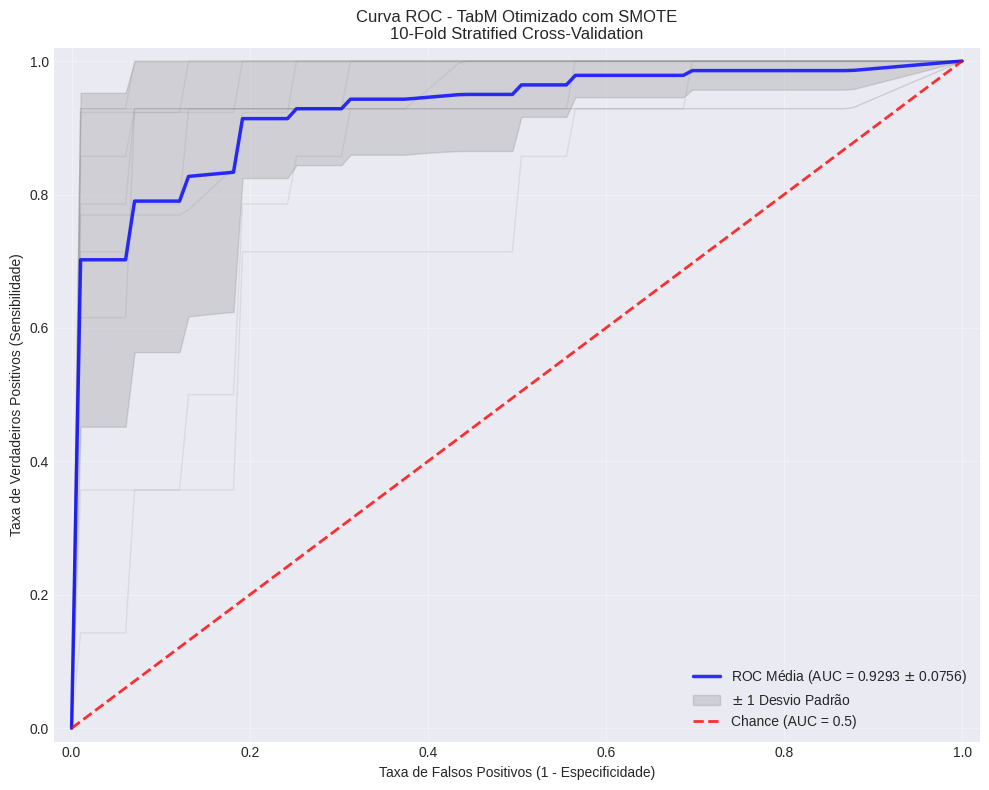

2. Matriz de Confusão Agregada...


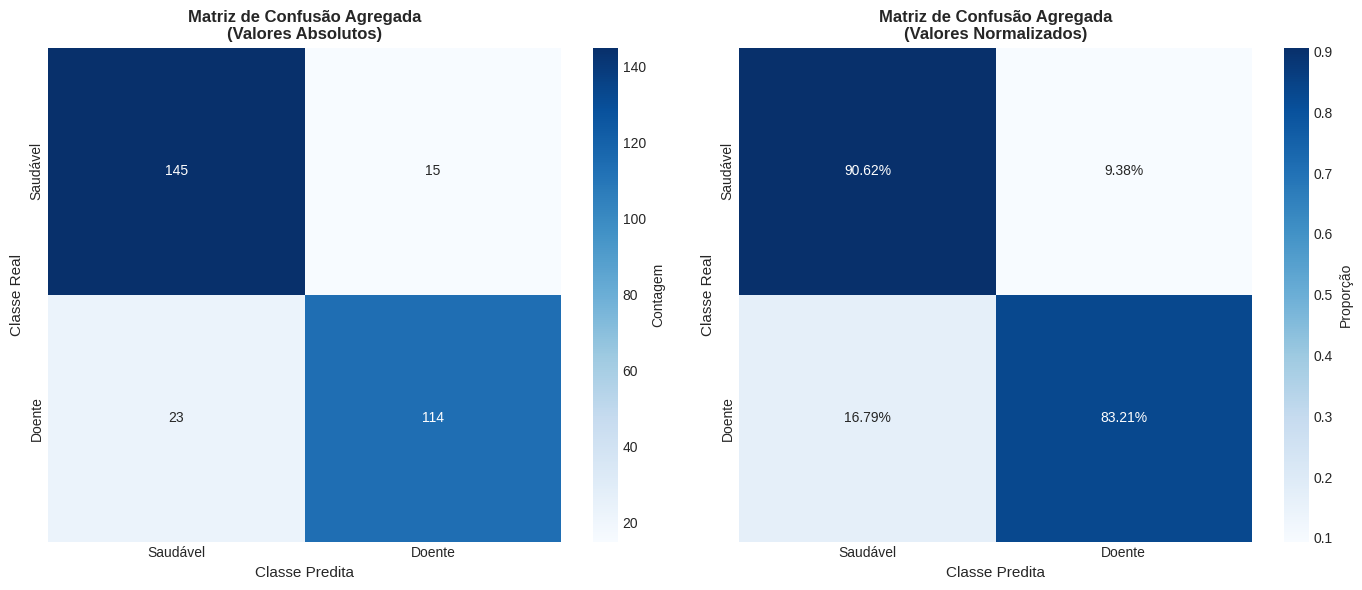

3. Boxplot das Métricas...


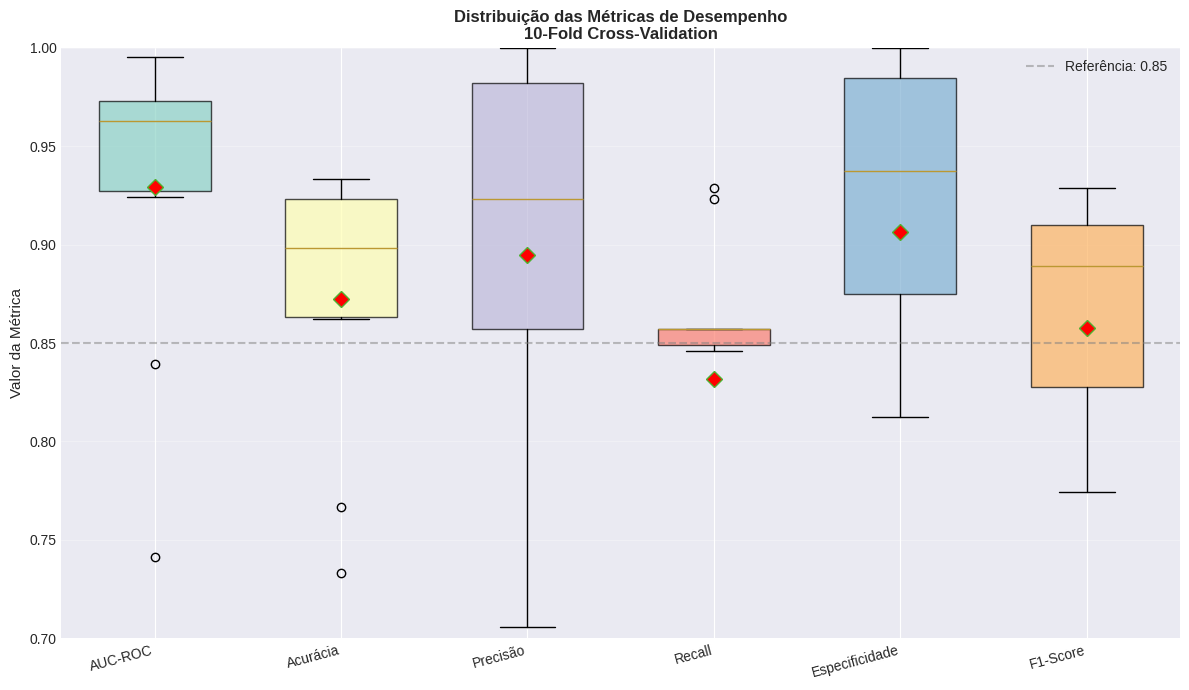

4. Métricas por Fold...


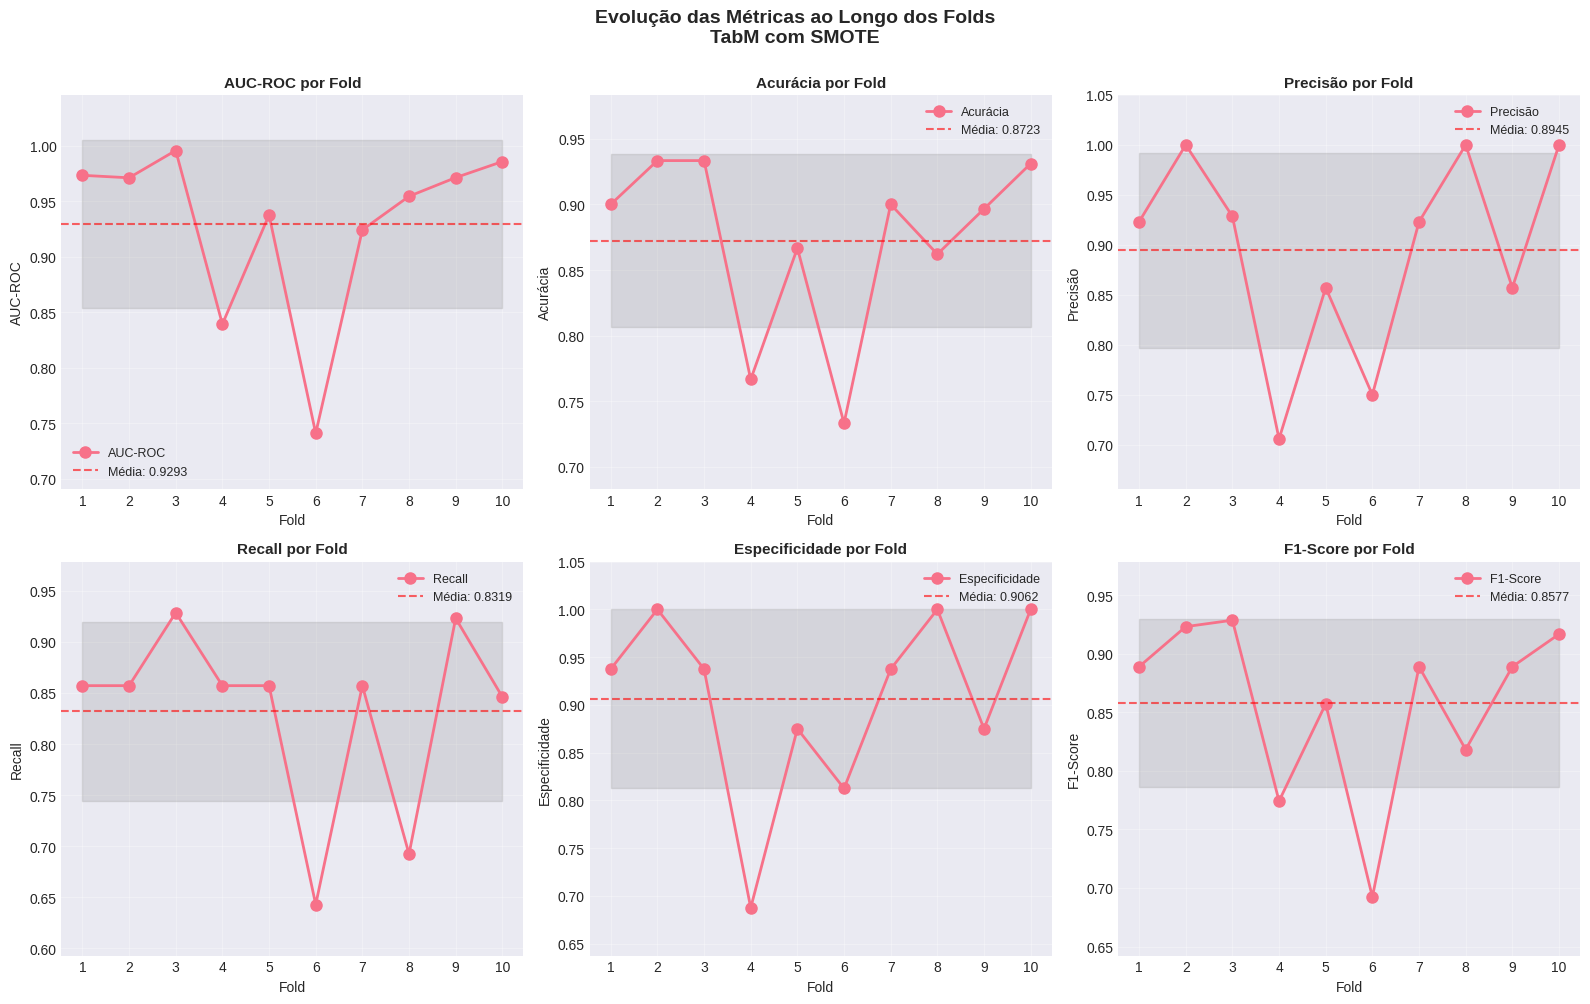

5. Distribuição de Thresholds...


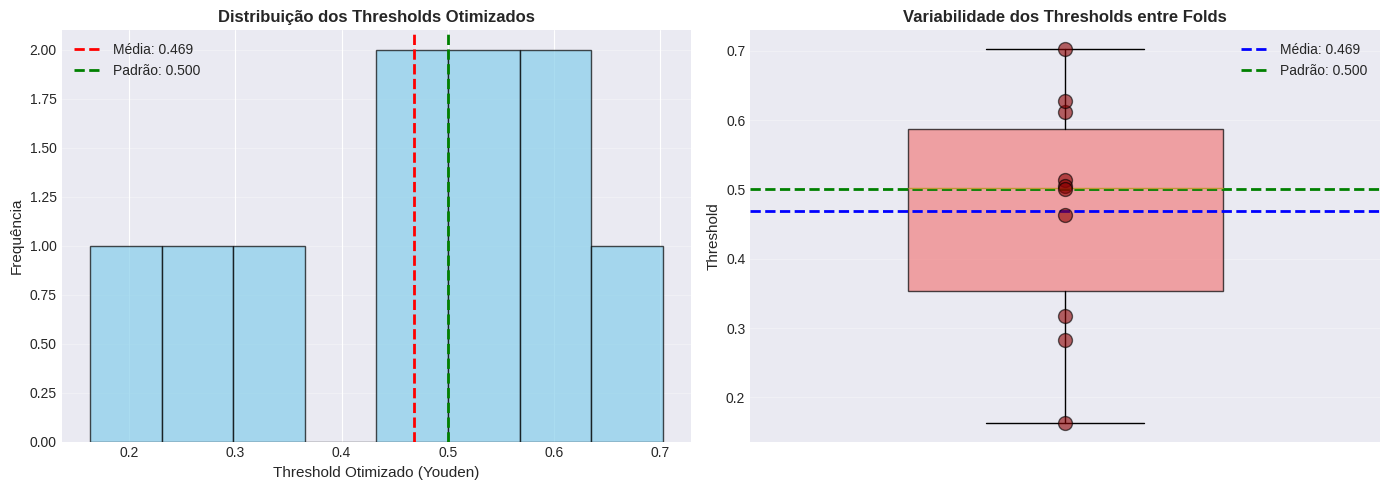

6. Impacto do SMOTE...


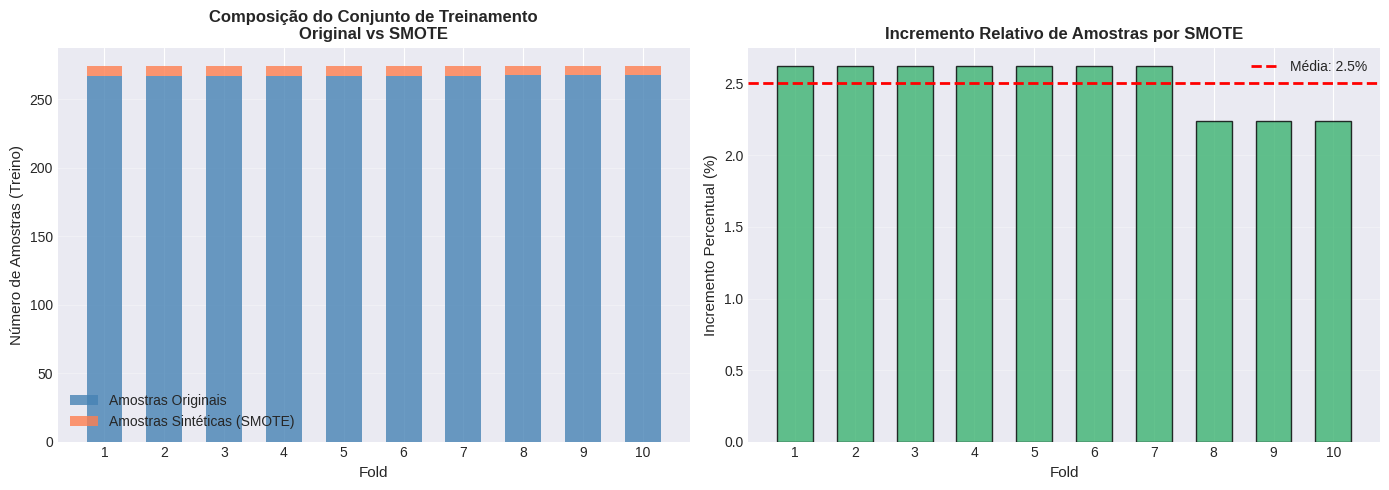

7. Tabela Comparativa Visual...


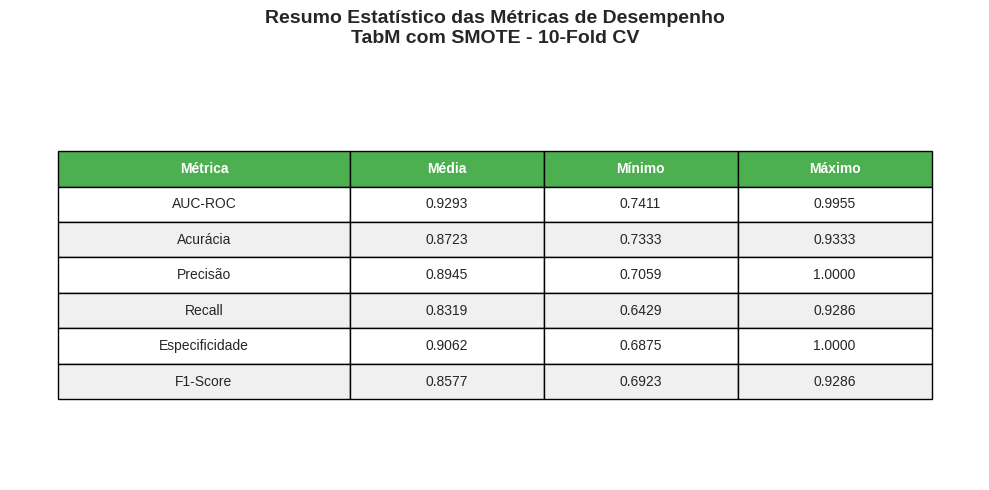


VISUALIZAÇÕES E ANÁLISES CONCLUÍDAS


In [13]:
# ================================================================================
# CÉLULA 7: VISUALIZAÇÕES E ANÁLISES DOS RESULTADOS
# ================================================================================
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle

# Configurações de estilo
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

def print_metrics_table(results):
    """Imprime tabela formatada das métricas para fácil cópia"""
    fold_results = results['fold_results']

    print("\n" + "="*80)
    print("TABELA DE MÉTRICAS DE DESEMPENHO - RESUMO ESTATÍSTICO")
    print("="*80)

    metrics_data = {
        'AUC-ROC': fold_results['auc_roc'],
        'Acurácia': fold_results['accuracy_opt'],
        'Precisão': fold_results['precision_opt'],
        'Recall': fold_results['recall_opt'],
        'Especificidade': fold_results['specificity_opt'],
        'F1-Score': fold_results['f1_opt']
    }

    # Cabeçalho da tabela
    print(f"{'Métrica':<20} {'Média':<15} {'Mínimo':<15} {'Máximo':<15}")
    print("-" * 80)

    # Linhas de dados
    for metric_name, values in metrics_data.items():
        mean_val = np.mean(values)
        min_val = np.min(values)
        max_val = np.max(values)

        # Formato: valor decimal e percentual
        mean_str = f"{mean_val:.4f} ({mean_val*100:.2f}%)"
        min_str = f"{min_val:.4f} ({min_val*100:.2f}%)"
        max_str = f"{max_val:.4f} ({max_val*100:.2f}%)"

        print(f"{metric_name:<20} {mean_str:<15} {min_str:<15} {max_str:<15}")

    print("="*80)

    # Informações adicionais
    print(f"\nThreshold Otimizado (Youden):")
    print(f"  Média: {np.mean(fold_results['threshold_opt']):.4f}")
    print(f"  Intervalo: [{np.min(fold_results['threshold_opt']):.4f}, {np.max(fold_results['threshold_opt']):.4f}]")

    # Matriz de confusão agregada
    cm = results['cm_aggregated']
    tn, fp, fn, tp = cm.ravel()

    print(f"\nMatriz de Confusão Agregada:")
    print(f"{'':>20} {'Predito Saudável':<20} {'Predito Doente':<20}")
    print(f"{'Real Saudável':<20} {tn:<20} {fp:<20}")
    print(f"{'Real Doente':<20} {fn:<20} {tp:<20}")

    print(f"\nTaxas de Erro:")
    print(f"  Falsos Negativos: {fn}/{fn+tp} ({fn/(fn+tp)*100:.2f}%)")
    print(f"  Falsos Positivos: {fp}/{fp+tn} ({fp/(fp+tn)*100:.2f}%)")

    print("="*80 + "\n")

def plot_roc_curve_aggregated(results):
    """Plota curva ROC agregada com intervalo de confiança"""
    fig, ax = plt.subplots(figsize=(10, 8))

    # Plotar curvas individuais dos folds (semi-transparentes)
    for i in range(len(results['tprs'])):
        fpr_fold = results['mean_fpr']
        tpr_fold = results['tprs'][i]
        ax.plot(fpr_fold, tpr_fold, lw=1, alpha=0.15, color='gray')

    # Calcular curva média e intervalo de confiança
    mean_tpr = np.mean(results['tprs'], axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = np.mean(results['aucs'])
    std_auc = np.std(results['aucs'])

    # Plotar curva média
    ax.plot(results['mean_fpr'], mean_tpr, color='b',
            label=r'ROC Média (AUC = %0.4f $\pm$ %0.4f)' % (mean_auc, std_auc),
            lw=2.5, alpha=.8)

    # Intervalo de confiança (±1 desvio padrão)
    std_tpr = np.std(results['tprs'], axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(results['mean_fpr'], tprs_lower, tprs_upper,
                     color='grey', alpha=.25, label=r'$\pm$ 1 Desvio Padrão')

    # Linha de chance
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance (AUC = 0.5)', alpha=.8)

    # Configurações do gráfico
    ax.set(xlim=[-0.02, 1.02], ylim=[-0.02, 1.02],
           xlabel='Taxa de Falsos Positivos (1 - Especificidade)',
           ylabel='Taxa de Verdadeiros Positivos (Sensibilidade)',
           title='Curva ROC - TabM Otimizado com SMOTE\n10-Fold Stratified Cross-Validation')
    ax.legend(loc="lower right", fontsize=10)
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix_aggregated(results):
    """Plota matriz de confusão agregada normalizada e absoluta"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    cm = results['cm_aggregated']

    # Matriz absoluta
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Saudável', 'Doente'],
                yticklabels=['Saudável', 'Doente'],
                cbar_kws={'label': 'Contagem'})
    axes[0].set_title('Matriz de Confusão Agregada\n(Valores Absolutos)', fontsize=12, fontweight='bold')
    axes[0].set_ylabel('Classe Real', fontsize=11)
    axes[0].set_xlabel('Classe Predita', fontsize=11)

    # Matriz normalizada
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues', ax=axes[1],
                xticklabels=['Saudável', 'Doente'],
                yticklabels=['Saudável', 'Doente'],
                cbar_kws={'label': 'Proporção'})
    axes[1].set_title('Matriz de Confusão Agregada\n(Valores Normalizados)', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Classe Real', fontsize=11)
    axes[1].set_xlabel('Classe Predita', fontsize=11)

    plt.tight_layout()
    plt.show()

def plot_metrics_boxplot(results):
    """Plota boxplots das métricas por fold"""
    fold_results = results['fold_results']

    metrics_data = {
        'AUC-ROC': fold_results['auc_roc'],
        'Acurácia': fold_results['accuracy_opt'],
        'Precisão': fold_results['precision_opt'],
        'Recall': fold_results['recall_opt'],
        'Especificidade': fold_results['specificity_opt'],
        'F1-Score': fold_results['f1_opt']
    }

    fig, ax = plt.subplots(figsize=(12, 7))

    positions = range(1, len(metrics_data) + 1)
    bp = ax.boxplot([metrics_data[k] for k in metrics_data.keys()],
                     positions=positions,
                     widths=0.6,
                     patch_artist=True,
                     showmeans=True,
                     meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

    # Colorir boxes
    colors = plt.cm.Set3(range(len(metrics_data)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)

    ax.set_xticklabels(metrics_data.keys(), rotation=15, ha='right')
    ax.set_ylabel('Valor da Métrica', fontsize=11)
    ax.set_title('Distribuição das Métricas de Desempenho\n10-Fold Cross-Validation',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0.7, 1.0])

    # Adicionar linha de referência
    ax.axhline(y=0.85, color='gray', linestyle='--', alpha=0.5, label='Referência: 0.85')
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_metrics_per_fold(results):
    """Plota evolução das métricas por fold"""
    fold_results = results['fold_results']
    folds = range(1, N_SPLITS + 1)

    fig, axes = plt.subplots(2, 3, figsize=(16, 10))
    axes = axes.ravel()

    metrics = [
        ('AUC-ROC', fold_results['auc_roc']),
        ('Acurácia', fold_results['accuracy_opt']),
        ('Precisão', fold_results['precision_opt']),
        ('Recall', fold_results['recall_opt']),
        ('Especificidade', fold_results['specificity_opt']),
        ('F1-Score', fold_results['f1_opt'])
    ]

    for idx, (metric_name, values) in enumerate(metrics):
        ax = axes[idx]

        # Plotar linha com marcadores
        ax.plot(folds, values, marker='o', linewidth=2, markersize=8, label=metric_name)

        # Linha da média
        mean_val = np.mean(values)
        ax.axhline(y=mean_val, color='red', linestyle='--', alpha=0.6,
                   label=f'Média: {mean_val:.4f}')

        # Banda de desvio padrão
        std_val = np.std(values)
        ax.fill_between(folds, mean_val - std_val, mean_val + std_val,
                        alpha=0.2, color='gray')

        ax.set_xlabel('Fold', fontsize=10)
        ax.set_ylabel(metric_name, fontsize=10)
        ax.set_title(f'{metric_name} por Fold', fontsize=11, fontweight='bold')
        ax.legend(loc='best', fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.set_xticks(folds)
        ax.set_ylim([min(values) - 0.05, max(values) + 0.05])

    plt.suptitle('Evolução das Métricas ao Longo dos Folds\nTabM com SMOTE',
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    plt.show()

def plot_threshold_distribution(results):
    """Plota distribuição dos thresholds otimizados"""
    fold_results = results['fold_results']
    thresholds = fold_results['threshold_opt']

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histograma
    axes[0].hist(thresholds, bins=8, edgecolor='black', alpha=0.7, color='skyblue')
    axes[0].axvline(np.mean(thresholds), color='red', linestyle='--', linewidth=2,
                    label=f'Média: {np.mean(thresholds):.3f}')
    axes[0].axvline(0.5, color='green', linestyle='--', linewidth=2,
                    label='Padrão: 0.500')
    axes[0].set_xlabel('Threshold Otimizado (Youden)', fontsize=11)
    axes[0].set_ylabel('Frequência', fontsize=11)
    axes[0].set_title('Distribuição dos Thresholds Otimizados', fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3, axis='y')

    # Box plot por fold
    axes[1].boxplot(thresholds, vert=True, widths=0.5, patch_artist=True,
                    boxprops=dict(facecolor='lightcoral', alpha=0.7))
    axes[1].scatter(np.ones(len(thresholds)), thresholds, alpha=0.6, s=100,
                    c='darkred', edgecolors='black', linewidths=1, zorder=3)
    axes[1].axhline(np.mean(thresholds), color='blue', linestyle='--', linewidth=2,
                    label=f'Média: {np.mean(thresholds):.3f}')
    axes[1].axhline(0.5, color='green', linestyle='--', linewidth=2,
                    label='Padrão: 0.500')
    axes[1].set_ylabel('Threshold', fontsize=11)
    axes[1].set_title('Variabilidade dos Thresholds entre Folds', fontsize=12, fontweight='bold')
    axes[1].set_xticks([])
    axes[1].legend()
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

def plot_smote_impact(results):
    """Visualiza o impacto do SMOTE"""
    fold_results = results['fold_results']
    smote_info = fold_results['smote_info']

    if not smote_info:
        print("Informações de SMOTE não disponíveis.")
        return

    folds = [info['fold'] for info in smote_info]
    original = [info['original_size'] for info in smote_info]
    smote_size = [info['smote_size'] for info in smote_info]
    synthetic = [info['increase'] for info in smote_info]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Gráfico de barras empilhadas
    width = 0.6
    axes[0].bar(folds, original, width, label='Amostras Originais', color='steelblue', alpha=0.8)
    axes[0].bar(folds, synthetic, width, bottom=original, label='Amostras Sintéticas (SMOTE)',
                color='coral', alpha=0.8)
    axes[0].set_xlabel('Fold', fontsize=11)
    axes[0].set_ylabel('Número de Amostras (Treino)', fontsize=11)
    axes[0].set_title('Composição do Conjunto de Treinamento\nOriginal vs SMOTE',
                     fontsize=12, fontweight='bold')
    axes[0].legend()
    axes[0].set_xticks(folds)
    axes[0].grid(True, alpha=0.3, axis='y')

    # Gráfico de incremento percentual
    percentual = [(s/o)*100 for s, o in zip(synthetic, original)]
    axes[1].bar(folds, percentual, width, color='mediumseagreen', alpha=0.8, edgecolor='black')
    axes[1].axhline(np.mean(percentual), color='red', linestyle='--', linewidth=2,
                    label=f'Média: {np.mean(percentual):.1f}%')
    axes[1].set_xlabel('Fold', fontsize=11)
    axes[1].set_ylabel('Incremento Percentual (%)', fontsize=11)
    axes[1].set_title('Incremento Relativo de Amostras por SMOTE', fontsize=12, fontweight='bold')
    axes[1].legend()
    axes[1].set_xticks(folds)
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.show()

def plot_performance_comparison_table(results):
    """Cria tabela visual comparativa de desempenho"""
    fold_results = results['fold_results']

    metrics_summary = {
        'Métrica': ['AUC-ROC', 'Acurácia', 'Precisão', 'Recall', 'Especificidade', 'F1-Score'],
        'Média': [
            np.mean(fold_results['auc_roc']),
            np.mean(fold_results['accuracy_opt']),
            np.mean(fold_results['precision_opt']),
            np.mean(fold_results['recall_opt']),
            np.mean(fold_results['specificity_opt']),
            np.mean(fold_results['f1_opt'])
        ],
        'Mínimo': [
            np.min(fold_results['auc_roc']),
            np.min(fold_results['accuracy_opt']),
            np.min(fold_results['precision_opt']),
            np.min(fold_results['recall_opt']),
            np.min(fold_results['specificity_opt']),
            np.min(fold_results['f1_opt'])
        ],
        'Máximo': [
            np.max(fold_results['auc_roc']),
            np.max(fold_results['accuracy_opt']),
            np.max(fold_results['precision_opt']),
            np.max(fold_results['recall_opt']),
            np.max(fold_results['specificity_opt']),
            np.max(fold_results['f1_opt'])
        ]
    }

    fig, ax = plt.subplots(figsize=(10, 5))
    ax.axis('tight')
    ax.axis('off')

    # Criar tabela
    table_data = []
    for i in range(len(metrics_summary['Métrica'])):
        row = [
            metrics_summary['Métrica'][i],
            f"{metrics_summary['Média'][i]:.4f}",
            f"{metrics_summary['Mínimo'][i]:.4f}",
            f"{metrics_summary['Máximo'][i]:.4f}"
        ]
        table_data.append(row)

    table = ax.table(cellText=table_data,
                     colLabels=['Métrica', 'Média', 'Mínimo', 'Máximo'],
                     cellLoc='center',
                     loc='center',
                     colWidths=[0.30, 0.20, 0.20, 0.20])

    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Estilizar cabeçalho
    for i in range(4):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Colorir linhas alternadas
    for i in range(1, len(table_data) + 1):
        for j in range(4):
            if i % 2 == 0:
                table[(i, j)].set_facecolor('#f0f0f0')

    plt.title('Resumo Estatístico das Métricas de Desempenho\nTabM com SMOTE - 10-Fold CV',
             fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

# Executar todas as visualizações
if 'results' in globals():
    print("\n" + "="*80)
    print("GERANDO VISUALIZAÇÕES E TABELAS")
    print("="*80 + "\n")

    # PRIMEIRO: Imprimir tabela formatada
    print_metrics_table(results)

    print("1. Curva ROC Agregada...")
    plot_roc_curve_aggregated(results)

    print("2. Matriz de Confusão Agregada...")
    plot_confusion_matrix_aggregated(results)

    print("3. Boxplot das Métricas...")
    plot_metrics_boxplot(results)

    print("4. Métricas por Fold...")
    plot_metrics_per_fold(results)

    print("5. Distribuição de Thresholds...")
    plot_threshold_distribution(results)

    print("6. Impacto do SMOTE...")
    plot_smote_impact(results)

    print("7. Tabela Comparativa Visual...")
    plot_performance_comparison_table(results)

    print("\n" + "="*80)
    print("VISUALIZAÇÕES E ANÁLISES CONCLUÍDAS")
    print("="*80)
else:
    print("Execute a célula de experimento final primeiro!")

Executando análise no último fold...
Treinando modelo para análise

>>> Análise de Incerteza e Features <<<


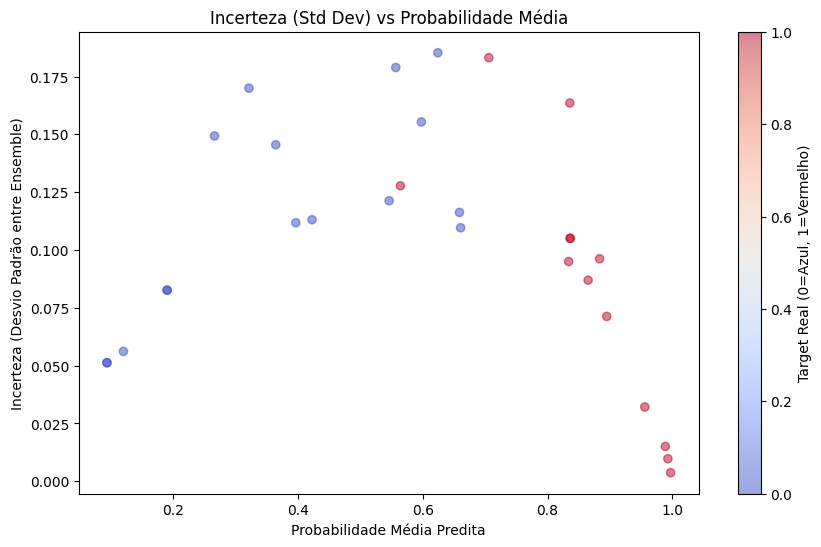

Incerteza média: 0.1026
Exemplo de alta incerteza (Index 9): Prob=0.62, Std=0.19

Calculando Importância de Features (Permutação)...


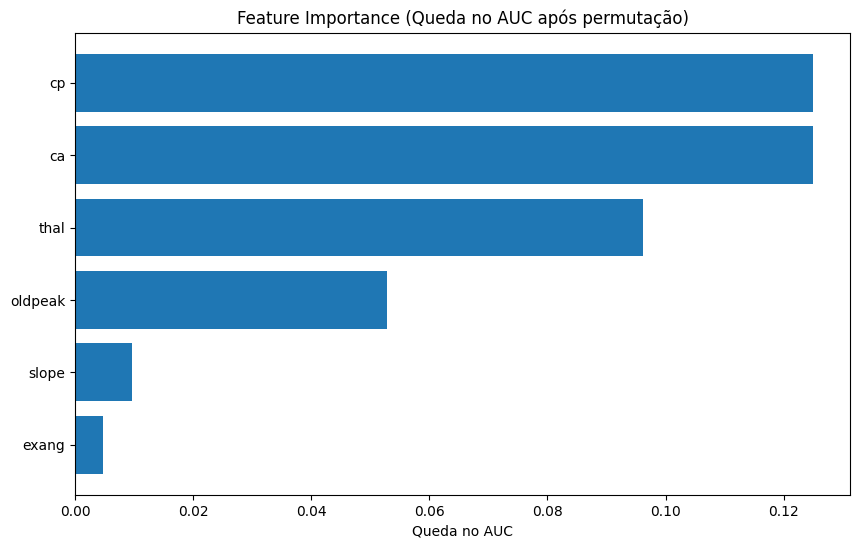

In [12]:
# ================================================================================
# CÉLULA 7: ESTIMATIVA DE INCERTEZA E IMPORTÂNCIA DE FEATURES
# ================================================================================

def analyze_uncertainty_and_features(model, X_num_val, X_cat_val, y_val, feature_names):
    """
    Analisa a incerteza das predições e a importância das features via permutação.
    """
    print("\n>>> Análise de Incerteza e Features <<<")
    model.eval()
    
    # 1. Incerteza (Desvio Padrão do Ensemble)
    X_num_t = torch.tensor(X_num_val).to(DEVICE)
    X_cat_t = torch.tensor(X_cat_val).to(DEVICE)
    
    with torch.no_grad():
        # Shape: (batch, k, 1)
        y_pred_raw = model(X_num_t, X_cat_t)
        probs_ensemble = torch.sigmoid(y_pred_raw).squeeze(-1).cpu().numpy() # (batch, k)
        
    # Média e Desvio Padrão das probabilidades
    mean_probs = probs_ensemble.mean(axis=1)
    std_probs = probs_ensemble.std(axis=1)
    
    # Plotar relação Probabilidade x Incerteza
    plt.figure(figsize=(10, 6))
    plt.scatter(mean_probs, std_probs, alpha=0.5, c=y_val, cmap='coolwarm')
    plt.colorbar(label='Target Real (0=Azul, 1=Vermelho)')
    plt.title("Incerteza (Std Dev) vs Probabilidade Média")
    plt.xlabel("Probabilidade Média Predita")
    plt.ylabel("Incerteza (Desvio Padrão entre Ensemble)")
    plt.show()
    
    print(f"Incerteza média: {std_probs.mean():.4f}")
    print(f"Exemplo de alta incerteza (Index {np.argmax(std_probs)}): Prob={mean_probs[np.argmax(std_probs)]:.2f}, Std={std_probs.max():.2f}")
    
    # 2. Importância de Features (Permutation Importance)
    print("\nCalculando Importância de Features (Permutação)...")
    baseline_auc = roc_auc_score(y_val, mean_probs)
    importances = {}
    
    # Features Numéricas
    for i, name in enumerate(feature_names[:len(feature_names_num)]): # Assumindo ordem numéricas primeiro
        X_num_permuted = X_num_val.copy()
        np.random.shuffle(X_num_permuted[:, i])
        
        with torch.no_grad():
            y_p = model(torch.tensor(X_num_permuted).to(DEVICE), X_cat_t)
            prob_perm = torch.sigmoid(y_p).mean(dim=1).squeeze().cpu().numpy()
            
        perm_auc = roc_auc_score(y_val, prob_perm)
        importances[name] = baseline_auc - perm_auc
        
    # Features Categóricas
    for i, name in enumerate(feature_names[len(feature_names_num):]):
        X_cat_permuted = X_cat_val.copy()
        np.random.shuffle(X_cat_permuted[:, i])
        
        with torch.no_grad():
            y_p = model(X_num_t, torch.tensor(X_cat_permuted).to(DEVICE))
            prob_perm = torch.sigmoid(y_p).mean(dim=1).squeeze().cpu().numpy()
        
        perm_auc = roc_auc_score(y_val, prob_perm)
        importances[name] = baseline_auc - perm_auc
        
    # Plotar Importâncias
    sorted_feats = sorted(importances.items(), key=lambda x: x[1], reverse=True)
    names, vals = zip(*sorted_feats)
    
    plt.figure(figsize=(10, 6))
    plt.barh(names, vals)
    plt.gca().invert_yaxis()
    plt.title("Feature Importance (Queda no AUC após permutação)")
    plt.xlabel("Queda no AUC")
    plt.show()

print("Executando análise no último fold...")
# Recriar split do último fold manualmente para análise
skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=RANDOM_STATE)
splits = list(skf.split(X_num, y))
last_train_idx, last_val_idx = splits[-1]

X_num_val_last = X_num[last_val_idx]
X_cat_val_last = X_cat[last_val_idx]
y_val_last = y[last_val_idx]


if 'best_params' in globals():
    final_model = create_tabm_model(len(feature_names_num), cat_cardinalities, best_params, X_train=torch.tensor(X_num[last_train_idx])).to(DEVICE)
    # Treino rápido para ter pesos não-aleatórios
    opt = optim.AdamW(final_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
    crit = nn.BCEWithLogitsLoss()
    loader = DataLoader(TensorDataset(torch.tensor(X_num[last_train_idx]), torch.tensor(X_cat[last_train_idx]), torch.tensor(y[last_train_idx])), batch_size=256, shuffle=True)
    
    print("Treinando modelo para análise")
    for _ in range(50):
        train_epoch(final_model, loader, opt, crit, DEVICE)
        
    all_features = feature_names_num + feature_names_cat
    analyze_uncertainty_and_features(final_model, X_num_val_last, X_cat_val_last, y_val_last, all_features)
else:
    print("Execute a otimização primeiro.")